# Lecture 9: Models: Simple Linear Regression and Multiple Regression

## Goals
- **Neuroscience / Neuroimaging concepts**
    - How to model and estimate voxel responses to different conditions
    - Simulating a signal
    - Design Matrix
- **Datascience / Coding concepts**
    - Statistical Models
    - Simple Linear Regression
    - Cost functions: Sum of Squared Errors (SSE)
    - Relationship between correlation and regression
    - Multiple Regression

# Setup

Simply run the cells below that contain all the Python modules we'll neeed, plus setup matplotlib for plotting in this jupyter notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats
from scipy.stats import zscore
import nibabel
import cortex
import os
from nistats.hemodynamic_models import glover_hrf as create_hrf

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, widgets, FloatSlider

np.random.seed(42)

# Set plotting defaults
%matplotlib inline

## Helper Functions
Define a few helper functions that we'll use in this lecture.

In [2]:
def load_nifti(file_name, mask=None):
    img = nibabel.load(file_name)
    data = img.get_data().T
    if mask is None:
        masked_data = data
    else:
        masked_data = data[:, mask]
    return masked_data

In [3]:
def plot_line_product(x, y, label_x='X', label_y='Y'):
    plt.plot(x, label=label_x)
    plt.plot(y, label=label_y)
    plt.bar(np.arange(len(x)), x*y, label="Product")
    _ = plt.legend()

In [4]:
def show_error_time(x, y, slope, intercept):
    """Plots the whole thing as a time series instead of a point cloud"""
    n = x.shape[0]
    plt.plot(y, 'b')
    plt.hlines([0], x.min(), x.max())
    num_x = 1 if x.ndim == 1 else x.shape[1]
    t = np.arange(n)
    new_x = np.zeros((n,))
    for cur_x in range(num_x):
        cur_x = (intercept + slope[cur_x] * x[:,cur_x])
        new_x += cur_x 
    plt.plot(new_x, 'r', lw=1)
    plt.fill_between(t, new_x, y[:,0], color='g', alpha=.5)

In [5]:
def show_error_scatter(x, y, slope, intercept):
    x = x[:,0]
    y = y[:,0]
    x_left = x.min() - x.ptp() * .2
    x_right = x.max() + x.ptp() * .2
    y_est = slope * x + intercept
    y_left, y_right = slope * x_left + intercept, slope * x_right + intercept
    y_bottom, y_top = y.min() - y.ptp() * .2, y.max() + y.ptp() * .2
    xs = np.vstack([x, x])
    bars = np.vstack([y, y_est])
    plt.hlines([0], x_left, x_right)
    plt.vlines([0], y_bottom, y_top)
    plt.scatter(x, y)
    plt.plot([x_left, x_right], [y_left, y_right], 'r', lw=2)
    plt.plot([0, 0], [0, intercept], 'm', lw=2)
    plt.plot(xs, bars, 'g-.')
    plt.axis([x_left, x_right, y_bottom, y_top])
    return ((y_est - y) ** 2).sum()

In [6]:
def show_error_both_ways(x, y, slope, intercept):
    if x.ndim == 1:
        x = x.reshape(len(x),1)
    if y.ndim == 1:
        y = y.reshape(len(y),1)
    plt.figure(figsize=(20, 4))
    plt.axes([0, 0, .18, 1.])
    e = show_error_scatter(x, y, slope, intercept)
    plt.axes([.2, 0, .8, 1])
    show_error_time(x, y, [slope], intercept)
    print('Sum of squared error (SSE): %.04f' % (e))

# Review


## Load the visual category fMRI data

We'll start by loading the visual category localizer data that we've been using.

In [7]:
data01 = load_nifti("/data/cogneuro/fMRI/categories/s01_categories_01.nii.gz")
data02 = load_nifti("/data/cogneuro/fMRI/categories/s01_categories_02.nii.gz")
data03 = load_nifti("/data/cogneuro/fMRI/categories/s01_categories_03.nii.gz")

In [8]:
faces_voxel_1 = scipy.stats.zscore(data01[:, 6, 57, 37])
faces_voxel_2 = scipy.stats.zscore(data02[:, 6, 57, 37])
faces_voxel_3 = scipy.stats.zscore(data03[:, 6, 57, 37])
data_faces = np.concatenate((faces_voxel_1, faces_voxel_2, faces_voxel_3))

In [9]:
places_voxel_1 = scipy.stats.zscore(data01[:, 10, 62, 40])
places_voxel_2 = scipy.stats.zscore(data02[:, 10, 62, 40])
places_voxel_3 = scipy.stats.zscore(data03[:, 10, 62, 40])
data_places = np.concatenate((places_voxel_1, places_voxel_2, places_voxel_3))

Now load the stimulus category labels and create the stimulus vectors for all the categories

In [10]:
localizer_labels = np.load("/home/jovyan/catloc_experimental_conditions.npy")
faces_stimuli_vec = localizer_labels == 'faces'
bodies_stimuli_vec = localizer_labels == 'body'
places_stimuli_vec = localizer_labels == 'places'
objects_stimuli_vec = localizer_labels == 'object'
scrambled_stimuli_vec = localizer_labels == 'scrambled'

We'll create an HRF, and convolve it with each of the stimulus vectors to create the response vectors.

In [11]:
# create the HRF function
hrf = create_hrf(tr=2.0, oversampling=1, time_length=32)

# create the response vectors
faces_response_vec = np.convolve(faces_stimuli_vec, hrf)[:len(faces_stimuli_vec)]
bodies_response_vec = np.convolve(bodies_stimuli_vec, hrf)[:len(bodies_stimuli_vec)]
places_response_vec = np.convolve(places_stimuli_vec, hrf)[:len(places_stimuli_vec)]
objects_response_vec = np.convolve(objects_stimuli_vec, hrf)[:len(objects_stimuli_vec)]
scrambled_response_vec = np.convolve(scrambled_stimuli_vec, hrf)[:len(scrambled_stimuli_vec)]

And pull out the number of categories in the data, and create a vector that represents time for the data as well.

In [12]:
n_cat = len(faces_stimuli_vec)
t_cat = np.arange(0,(n_cat*2),2)

## Correlation

Last week we learned that correlation is a statistic that can be calculated to quantify the similarity of two random variables, and there are multiple ways to think about what exactly it does. We learned three:
* Correlation is the slope of a line that best reduces the squared error between z-scored data in a scatter plot.
* Correlation measures the extent to which two variables change together away from their respective means. 
* Correlation is the average product of the standardized scores of two variables.

Let's create some "fake" data and then review these three ways to think about correlation. First we'll create some constants that we can change later that adjust the size of the fake data and how correlated the two vectors are.

In [48]:
TARGET_CORRELATION = 0.6
FAKE_N = 50
MEAN_1 = 10
MEAN_2 = 0

Create the fake data with the means and correlation specified above

In [49]:
fake_data = np.random.multivariate_normal([MEAN_1,MEAN_2], [[1,TARGET_CORRELATION],[TARGET_CORRELATION,1]],FAKE_N)
fake_x = fake_data[:,0]
fake_y = fake_data[:,1]

Let's put that into a function since we'll use it later.

In [17]:
def create_fake_data(n, mean1, mean2, corr):
    fake_data = np.random.multivariate_normal([mean1,mean2], [[1,corr],[corr,1]],n)
    fake_x = fake_data[:,0]
    fake_y = fake_data[:,1]
    return (fake_x, fake_y)

We learned we can use the `np.corrcoef` function to compute the correlation between two variables. Let's use that to verify that these variables have a correlation coefficient close to what we specified (though it won't be exact due to randomness).

In [18]:
corr_fake = np.corrcoef(fake_x, fake_y)[0,1]
corr_fake

0.50762792187948635

#### Breakout Session

1\. Rerun the two code cells above that create the random data and calculate their correlation. You should see that the values of the correlation can be pretty different from what we specified.

2\. Now change `FAKE_N` to be `1000` instead of `50`, and rerun the two above code cells several times. How does this change the correlations calculated?

In [ ]:
### STUDENT ANSWER
### END STUDENT ANSWER

### Correlation as the Slope of a Line that Fits Standardized (Z-Scored) Data in a Scatter Plot

When we plot the data from two variables (stored in vectors) on a scatter plot, then the slope of the line that is closest to all the data points, on average, is the correlation. 

First we'll need to z-score both vectors, since correlation is done on standardized data. 

In [50]:
fake_x_zscore = scipy.stats.zscore(fake_x)
fake_y_zscore = scipy.stats.zscore(fake_y)

Next we'll use a scatter plot to visualize the data of the two variables, which shows the relationship between the data points of two variables. 

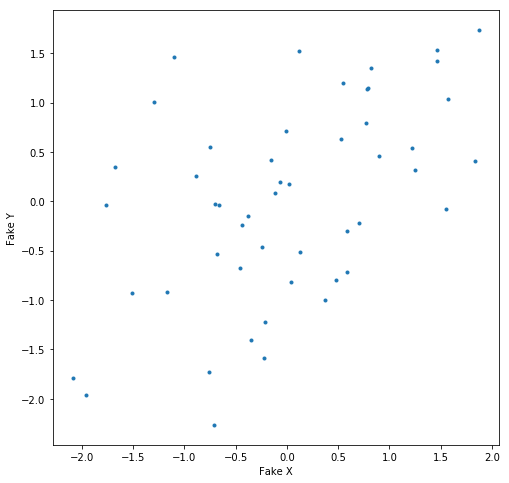

In [20]:
fig = plt.figure(figsize=(8,8))
plt.plot(fake_x_zscore, fake_y_zscore, '.')
plt.xlabel('Fake X')
_ = plt.ylabel('Fake Y')

Now let's add a line to the plot that best fits the line. Since we know that the slope of that line is the correlation, we can plot the line by using the `fake_x` vector as the x data, and multiplying `fake_x` by the correlation for the y data. Let's see.

In [1]:
var1 = 1*7+7
var1

14

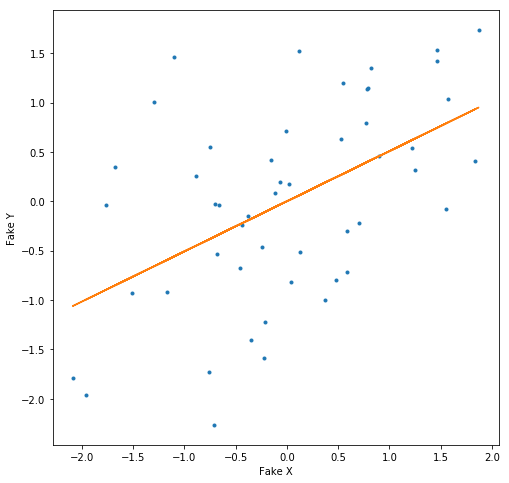

In [21]:
fig = plt.figure(figsize=(8,8))
plt.plot(fake_x_zscore, fake_y_zscore, '.')
plt.plot(fake_x_zscore, fake_x_zscore*corr_fake)
plt.xlabel('Fake X')
_ = plt.ylabel('Fake Y')

One important property of plotting the standardized data is that the correlation line always goes through the origin, or (0,0) point, of the plot. This is because the means of both vectors are zero (due to z-scoring), and correlation measures how two signals change together, relative to their respective means.  

#### Breakout Session

1\. Make a figure that is `figsize=(10,5)`, and use `plt.subplot` to make two scatter plots in the same row. The first plot should show the original fake data, and the second the z-scored fake data. Draw appropriate titles above each plot. Do they look similar or different? Why might this be?

(-2.3374814197241154,
 3.472758868364763,
 -2.663427209339277,
 3.1468130787496014)

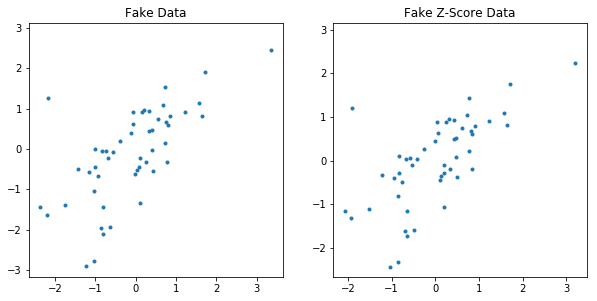

In [29]:
### STUDENT ANSWER
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(fake_x, fake_y, '.')
plt.title('Fake Data')
plt.axis('square')
plt.subplot(1,2,2)
plt.plot(fake_x_zscore, fake_y_zscore, '.')
plt.title('Fake Z-Score Data')
plt.axis('square')
### END STUDENT ANSWER

In [30]:
fake_x.mean()

-0.11571171419607937

In [31]:
fake_x.std()

1.0823560750115204

### Correlation as Two Signals Changing Together, Relative to their Respective Means

If we think of the 2 vectors to be correlated as time series data, then correlation is quantifying how similarily the two signals change at each time point relative to their means (since we z-score the data first, their means are both 0!). Thus if we plot the two z-scored vectors together in a line plot, we can get a visual idea of whether they change together or not. Let's compare the z-scored fake data vectors.

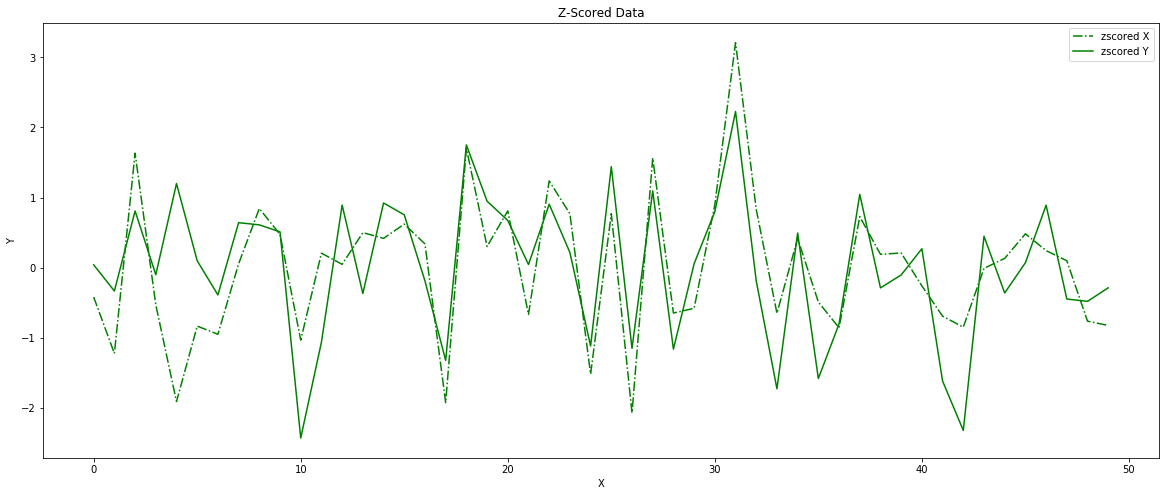

In [32]:
fig = plt.figure(figsize=(20, 8))
plt.plot(fake_x_zscore, 'g-.', label='zscored X')
plt.plot(fake_y_zscore, 'g', label='zscored Y')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Z-Scored Data')
_ = plt.legend()

They do seem to vary together fairly well, although not perfectly!

#### Breakout Session

1\. Create 2 new sets of fake x and y data, one with a correlation of 0.1 and with a correlation of 0.9.

In [33]:
### STUDENT ANSWER
fake_corr1_x, fake_corr1_y = create_fake_data(100, 0, 0, .1)
fake_corr9_x, fake_corr9_y = create_fake_data(100, 0, 0, .9)
### END STUDENT ANSWER

2\. Now z-score both pairs of x and y fake data.

In [34]:
### STUDENT ANSWER
fake_corr1_x_z = zscore(fake_corr1_x)
fake_corr1_y_z = zscore(fake_corr1_y)
fake_corr9_x_z = zscore(fake_corr9_x)
fake_corr9_y_z = zscore(fake_corr9_y)
### END STUDENT ANSWER

3\. Finally create a line plot for each pair of x and y fake data, each on its own row of a subplot.

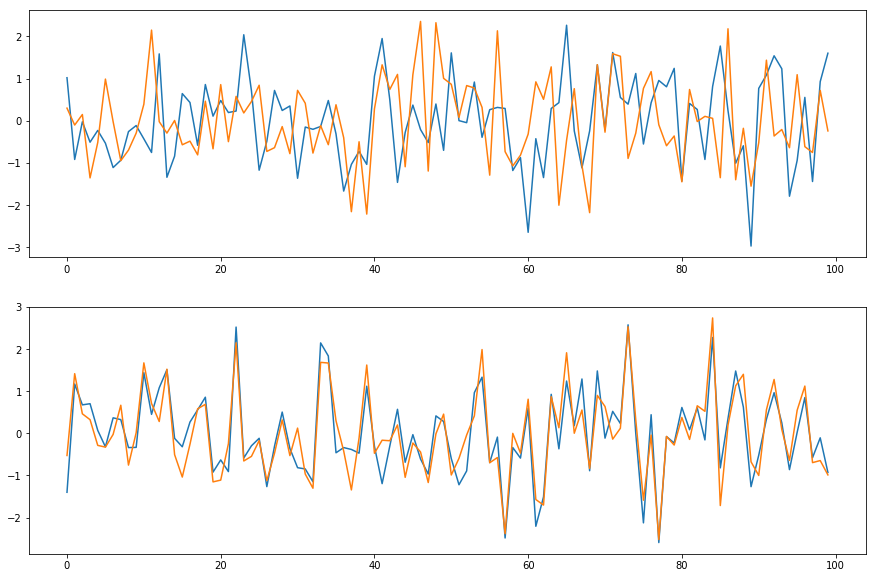

In [37]:
### STUDENT ANSWER
fig = plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(fake_corr1_x_z)
plt.plot(fake_corr1_y_z)
plt.subplot(2,1,2)
plt.plot(fake_corr9_x_z)
plt.plot(fake_corr9_y_z)
### END STUDENT ANSWER

### Correlation as the average product of standardized vectors

We know that when two vectors vary together in time they are correlated. But how do we quantify this? We learned that correlation can be thought of as:

> The average product of two standardized vectors.

In other words, once we have z-scored data, we can simply multiply each pair of data points, and take the average of all of those products. Let's have a look at how this works both visually and algebraically for a few different correlation values.

In [39]:
fake_x1, fake_y1 = create_fake_data(100, 0, 0, .1)
fake_x2, fake_y2 = create_fake_data(100, 0, 0, .5)
fake_x3, fake_y3 = create_fake_data(100, 0, 0, .9)

And z-score all the data.

In [40]:
fake_x1_z = zscore(fake_x1)
fake_x2_z = zscore(fake_x2)
fake_x3_z = zscore(fake_x3)
fake_y1_z = zscore(fake_y1)
fake_y2_z = zscore(fake_y2)
fake_y3_z = zscore(fake_y3)

Now let's plot the 3 pairs of fake data, along with their products. We'll use a helper function for this

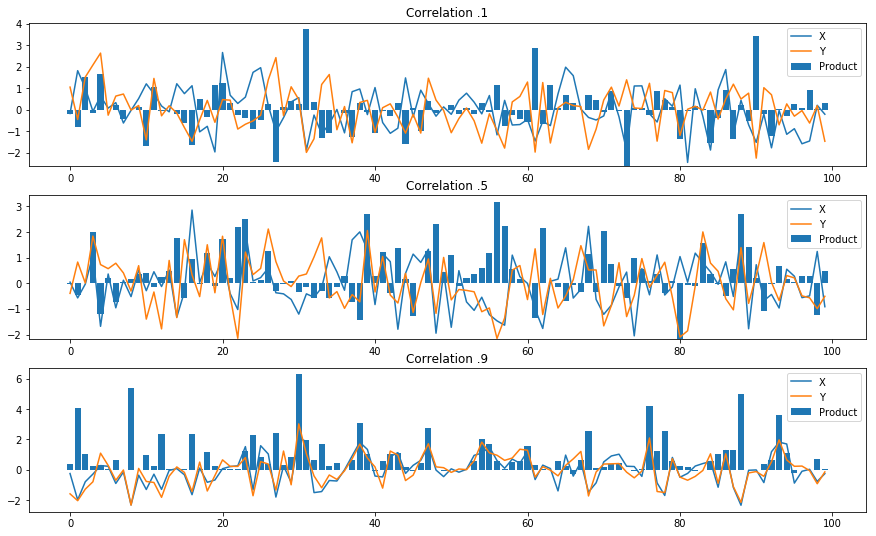

In [41]:
fig = plt.figure(figsize=(15,9))
plt.subplot(3,1,1)
plot_line_product(fake_x1_z, fake_y1_z)
plt.title('Correlation .1')
plt.subplot(3,1,2)
plot_line_product(fake_x2_z, fake_y2_z)
plt.title('Correlation .5')
plt.subplot(3,1,3)
plot_line_product(fake_x3_z, fake_y3_z)
_ = plt.title('Correlation .9')

Since we're averaging the products, when the products are all positive we can expect a high positive correlation, which we see in the bottom plot. But when they are both positive and negative they will cancel each other out, resulting in a correlation close to 0, which we see in the top plot.

Now let's calculate the average pairwise product of the two vectors:

In [42]:
corr_fake1 = np.mean(fake_x1_z*fake_y1_z)
corr_fake2 = np.mean(fake_x2_z*fake_y2_z)
corr_fake3 = np.mean(fake_x3_z*fake_y3_z)

And compare these values to what we get using `np.corrcoef`.

In [43]:
print(np.allclose(corr_fake1, np.corrcoef(fake_x1_z,fake_y1_z)[0,1]))
print(np.allclose(corr_fake2, np.corrcoef(fake_x2_z,fake_y2_z)[0,1]))
print(np.allclose(corr_fake3, np.corrcoef(fake_x3_z,fake_y3_z)[0,1]))

True
True
True


### Visualizing it all together

Now let's use an interactive plot that plots two data vectors using both a scatter plot and a time series plot to see how both visualizations change together when we add more data, or use more correlated data.

In [46]:
def plot_cor_time(n):

    # create a sequence for the length of the fake data
    t = range(n)
    
    # subset the fake data to the size specified by the slider
    cur_x = fake_x[:n]
    cur_y = fake_y[:n]

    # z-score (standardize) the fake data
    cur_x_z = scipy.stats.zscore(cur_x)
    cur_y_z = scipy.stats.zscore(cur_y)
    
    # take the mean of the fake data
    mean_fake_x = np.mean(cur_x)
    mean_fake_y = np.mean(cur_y)

    # calculate the correlation of the fake data
    fake_prods = (cur_x-mean_fake_x)*(cur_y-mean_fake_y)
    fake_mean_prods = np.mean(fake_prods)
    fake_prod_std = np.std(cur_x) * np.std(cur_y)
    fake_cor = fake_mean_prods / fake_prod_std

    # print out the values of the correlation
    print('Average of products: %.02f' % (fake_mean_prods))
    print('Product of std-dev: %.02f' % (fake_prod_std))
    print('Correlation: %.02f' % (fake_cor))

    # plot the line plots of the two variables
    plt.figure(figsize=(15,6))
    grid = plt.GridSpec(2,5)
    plt.subplot(grid[0,2:])
    plt.plot(t, cur_x, 'g', label='x')
    plt.plot(t, cur_x, 'go')
    plt.plot(t, cur_y, 'b', label='y')
    plt.plot(t, cur_y, 'bo')
    plt.plot(t, np.ones(n)*mean_fake_x, 'g--')
    plt.plot(t, np.ones(n)*mean_fake_y, 'b--')
    plt.legend()

    # plot the product of the difference between each data point and their respective means
    plt.subplot(grid[1,2:])
    plt.plot(t, np.ones(n)*fake_mean_prods, '--')
    plt.bar(t,fake_prods)

    # make a scatter plot of the standardized data, and draw the correlation line
    plt.subplot(grid[0:2,0:2])
    plt.scatter(cur_x_z, cur_y_z)
    fit = np.polyfit(cur_x_z, cur_y_z, deg=1)
    plt.plot(cur_x_z, fit[0] * cur_x_z + fit[1], color='red')
    plt.axis('square')

In [51]:
interactive_plot = interactive(plot_cor_time, n=widgets.IntSlider(value=2, min=2, max=len(fake_x)))
output = interactive_plot.children[-1]
output.layout.height = '450px'
interactive_plot

interactive(children=(IntSlider(value=2, description='n', max=50, min=2), Output(layout=Layout(height='450px'))), _dom_classes=('widget-interact',))

## Correlation quantifies linear dependency

Earlier in the lecture we were using correlation coefficient to assess how much two sets of numbers relate to each other. There are some assumptions behind this, which we will take a look at here.

The general intuition, when we say **"these quantities are correlated"**, it means: There is some form of **dependency** between the two quantities. Meaning: knowledge of the one quantity might gain us more knowledge about the other quantity. This is a **loose definition**, but there exist mathematical ideas to quantify this.

### When we say *correlation*, we usually refer to *linear correlation* (also called Pearson correlation)
Or to frame it as a question: **How much does the point cloud resemble a line?**

We saw above that when 2 vectors are linearly related, without noise, they formed a perfect line, meaning a perfect positive correlation of 1. Let's see that again.

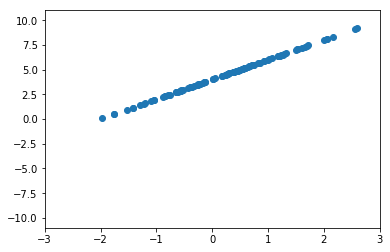

In [52]:
x = np.random.randn(100)
y = 2 * x + 4
plt.scatter(x, y)
_ = plt.axis([-3, 3, -11, 11])

In [53]:
np.corrcoef(x, y)

array([[ 1.,  1.],
       [ 1.,  1.]])

### Linear Correlation measured on a non-linear relation

There can be many different **non-linear** ways that two vectors can relate to each other, or be dependent on each other. One simple way is when one vector is the square of the other, resulting in a parabola when plotted on a scatter plot. Let's create a `height_squared` vector that shows just that. 

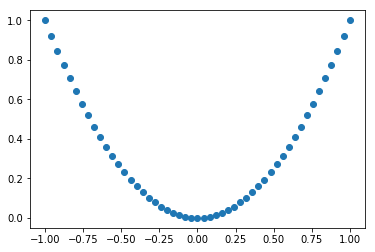

In [54]:
x = np.linspace(-1., 1., 51)
y = x ** 2
plt.plot(x, y, 'o')

We see that these two vectors create a parabola when plotted on a scatter plot! While there is definitely a precise relationship between the two arrays, correlation cannot detect that relationship because it only looks for linear relationships. Let's look at what the correlation between these vectors is.

In [55]:
np.corrcoef(x, y)

array([[  1.00000000e+00,  -2.38620432e-17],
       [ -2.38620432e-17,   1.00000000e+00]])

Basically exactly zero! Let's plot the correlation line along with the data

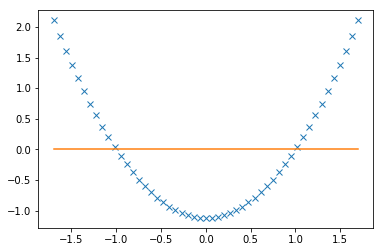

In [56]:
x_z = (x - x.mean()) / x.std()
y_z = (y - y.mean()) / y.std()
plt.plot(x_z, y_z, 'x')
c = np.mean(x_z * y_z)
plt.plot(x_z, c * y_z)

The correlation coefficient of this *perfect functional relation* is **zero**. Always keep this in mind when thinking about and evaluating correlation scores.

## Creating Correlation Flatmaps

In this section we will correlate all the voxels of a scan with the response vectors for the experiment. We will compute all of them together using array operations, and eventually even compute all of them together for stimulus types. Then we will display the results on flat maps.

### Preparing the data

Above we already loaded the BOLD data into the names `data1, data2, data3`. Let's check their shapes:

In [57]:
data01.shape, data02.shape, data03.shape

((120, 30, 100, 100), (120, 30, 100, 100), (120, 30, 100, 100))

Let's mask them to obtain the cortical voxels.

In [58]:
mask = cortex.db.get_mask('s01', 'catloc', 'cortical')

In [59]:
data1_masked = data01[:, mask]
data2_masked = data02[:, mask]
data3_masked = data03[:, mask]

Now let's perform z-scoring for the first array for all the voxels separately:

First, we compute the mean of each voxel time series:

In [60]:
data1_masked.shape

(120, 38543)

In [61]:
data1_mean = data1_masked.mean(axis=0)

In [62]:
data1_mean.shape

(38543,)

We see that taking the mean along axis 0 gives us a mean value for each voxel.

We can also take the standard deviation along this axis:

In [63]:
data1_stdev = data1_masked.std(axis=0)
data1_stdev.shape

(38543,)

Now we can do the z-scoring by subtracting the mean and dividing by the standard deviation for each column of the masked data array:

In [64]:
data1_zscored = (data1_masked - data1_mean) / data1_stdev

#### Breakout Session
1. Do z-scoring for the other two arrays
2. Use `np.concatenate` or `np.vstack` to stack all three matrices vertically into an array named `data_zscored`.

In [68]:
### STUDENT ANSWER
data2_zscored = zscore(data2_masked)
data3_zscored = zscore(data3_masked)
data_zscored = np.concatenate((data1_zscored, data2_zscored, data3_zscored))
### END STUDENT ANSWER

### Computing correlation of one response vector to all the voxels

In order to compute the correlation of a response vector to all the voxels, we will first spell out the multiplication of that one response vector to all voxels.

In [69]:
faces_response_zscored = zscore(faces_response_vec)
faces_response_times_voxels = faces_response_zscored * data_zscored

ValueError: operands could not be broadcast together with shapes (360,) (360,38543) 

Huh, that didn't work!

To make this work, we need to turn `faces_response_zscored` into a column vector of shape `(360, 1)`.

In [72]:
faces_response_zscored.shape

(360,)

In [73]:
faces_response_zscored_column.shape

(360, 1)

In [71]:
faces_response_zscored_column = faces_response_zscored.reshape(-1, 1)

In [75]:
data_zscored.shape

(360, 38543)

In [74]:
faces_response_times_voxels = faces_response_zscored_column * data_zscored

In [76]:
faces_response_times_voxels.shape

(360, 38543)

That worked. Now we can take the mean along the time axis to compute the correlations with each voxel.

In [77]:
corr_faces_data = faces_response_times_voxels.mean(axis=0)

In [78]:
corr_faces_data.shape

(38543,)

In [79]:
corr_faces_data.max(), corr_faces_data.min()

(0.61821396658409355, -0.40203299920497387)

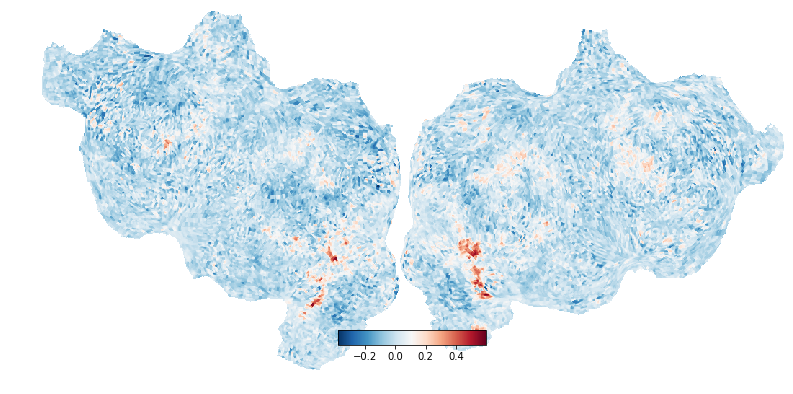

In [81]:
vol_faces = cortex.Volume(corr_faces_data, 's01', 'catloc')
_ = cortex.quickflat.make_figure(vol_faces)

We find that the `faces_response_zscored` correlates most strongly with voxels that we have already identified as belonging to areas processing faces!

#### Breakout Session
1. Compute the same correlation for `places` in the PPA voxel, and make a flatmap showing the correlation values. 

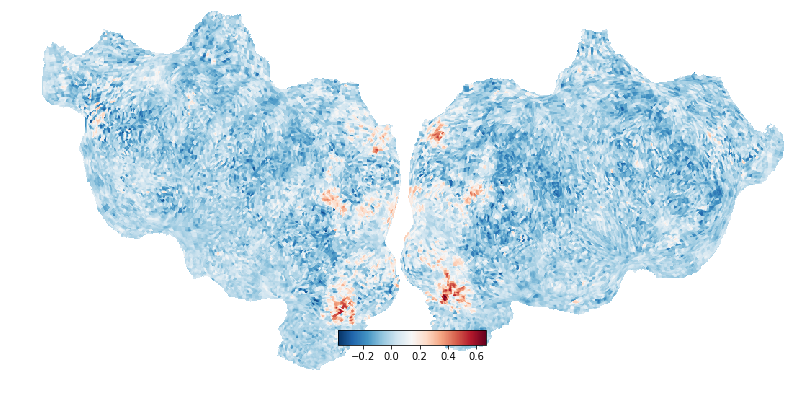

In [83]:
### STUDENT ANSWER
places_response_z = zscore(places_response_vec)
corr_places_data = (places_response_z.reshape(-1,1)*data_zscored).mean(axis=0)

vol_places = cortex.Volume(corr_places_data, 's01', 'catloc')
_ = cortex.quickflat.make_figure(vol_places)
### END STUDENT ANSWER

### Example: How does the HRF improve correlation?
Now that we have a metric that can quantify how similar two signals are (correlation), let's look and see how much more similar the response vectors that we calculated two weeks ago are to the BOLD data than the stimulus vectors.

In [84]:
corr_faces_stimuli = np.corrcoef(data_faces, faces_stimuli_vec)[0,1]
corr_faces_response = np.corrcoef(data_faces, faces_response_vec)[0,1]

print('Correlation between stimulus vector and BOLD data: %.06f' % (corr_faces_stimuli))
print('Correlation between response vector and BOLD data: %.06f' % (corr_faces_response))

Correlation between stimulus vector and BOLD data: 0.539242
Correlation between response vector and BOLD data: 0.618214


We see that considering the HRF does indeed improve the correlation for this voxel! Let's 

# Linear Regression

We've seen that correlation is a statistical technique that quantifies the linear relationship between two vectors of data by calculating the correlation coefficient, $r$. One way to think about correlation is that it finds a line that best fits the data when the standardized (z-scored) data is plotted in a scatter plot. **Linear regression** is also a statistical technique that finds the line that best fits data when plotted in a scatter plot, but it does not require that the data is standardized. 

## Independent vs. Dependent Variables
Another way to describe linear regression is that it finds the linear relationship between a single **dependent variable** (y) and one or more **independent variables** denoted (x). Thus **linear regression** is more powerful than correlation because it can quantify the relationship of many different **independent variables** with the **dependent variable**, whereas correlation only finds the relationship between two **variables**, neither of which is independent nor dependent. 

* **Dependent Variable**: This variable represents the data you've measured, and are trying to understand in terms of the independet variables. In our case, the BOLD data time series is the dependent variable.
* **Independent Variable**: These are the one or more variables that we're using to explain the dependent variable. These are generally not measured, rather their true values are known. In our case, the response vectors of all the visual categories or motor tasks are the independent variables. 

## The linear equation: `y = a*x + b`

We saw last week that we can create a data vector $y$ that is perfectly correlated with a data vector $x$ by using the linear equation: $$y = a*x+b$$

Then we can add noise to $y$ to decrease that correlation. The correlation coefficient, $r$, was neither $a$ nor $b$ however. 

Linear regression gives us a tool to find $a$ and $b$ if the correlation between $x$ and $y$ is perfect, or to estimate the values of $a$ and $b$ that make the average of all the linearly transformed values of $x$ as close as possible to the values of $y$.

So let's use some simple fake data to get a feeling for what $a$ and $b$ are using plots. We'll create 4 pairs of fake data with different values of $a$ and $b$.

In [85]:
def create_fake_linear(n, a, b):
    x = np.random.randn(n)
    y = a * x + b
    return (x,y)

In [86]:
fake_linear_x1, fake_linear_y1 = create_fake_linear(100, 1, 0)
fake_linear_x2, fake_linear_y2 = create_fake_linear(100, 1, 4)
fake_linear_x3, fake_linear_y3 = create_fake_linear(100, 2, 0)
fake_linear_x4, fake_linear_y4 = create_fake_linear(100, .3, -3)

Let's plot the four pairs of fake data onto a plot to see how changing $a$ and $b$ changes the line.

**NOTE**: Because we want to get a sense for the real slope of the line we must make sure the x and y axes are on the same scale. To do this we can use `plt.axis('square')`. If you don't do this the scales of the two axes will be automatically calculated by default and the angle of the line won't be the actual slope.

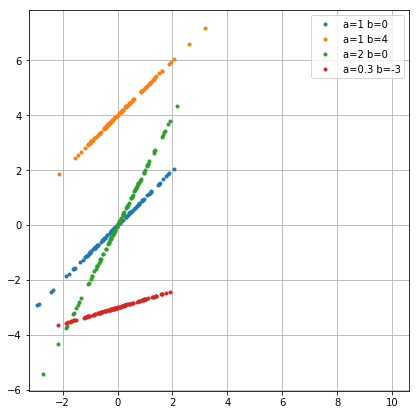

In [87]:
fig = plt.figure(figsize=(8,7))
plt.plot(fake_linear_x1, fake_linear_y1, '.', label='a=1 b=0')
plt.plot(fake_linear_x2, fake_linear_y2, '.', label='a=1 b=4')
plt.plot(fake_linear_x3, fake_linear_y3, '.', label='a=2 b=0')
plt.plot(fake_linear_x4, fake_linear_y4, '.', label='a=0.3 b=-3')
plt.grid()
plt.axis('square')
_ = plt.legend()

#### Breakout Session

1\. Think back to algebra class and determine what the slope and intercept are for the 4 fake data sets plotted in the cell above.

In [ ]:
### STUDENT ANSWER
### END STUDENT ANSWER

### Estimating the Slope: `a`

The slope of a line is it's angle, which represents the change in y for every change of 1 in x. It's often termed "Rise over Run" because it can be calculated be choosing any two points on the line and dividing the difference in y-values of those two points (the Rise) by the difference in the x-values (the Run).

In regression, we use the value of one or more variables (x) to predict the value of another (y). When the variables x and y are measured in standard units, the regression line for predicting y based on x has slope r and passes through the origin. Thus the equation of the regression line can be written as:

$$\hat{y} = r*x$$

where $r$ is the correlation coefficient, $\hat{y}$ is the **predicted value of y**, and when both $x$ and $y$ variables are measured in standard units (z-scored).
 
Generally we don't want to have to z-score the data in order to find a relationship between $x$ and $y$, and so we can write the linear regression equation in terms of the original units of the data. We do this by inverting the z-score operation, namely multiplying both variables by their respective standard deviations, and adding back in their respective means:

$$\frac{\hat{y} − \bar{y}}{SD_y} = r * \frac{x - \bar{x}}{SD_x}$$

The figures below give a visual representation of how the we arrive at the above equation.

<img src="figures/regline_z.png" align="left" style="height: 200px;"/>
<img src="figures/regline_orig.png" align="right" style="height: 200px;"/>

By rearranging the terms in the equation above, we can retrieve the equation for estimating the slope of the regresion line:
$$slope = r*\frac{SD_y}{SD_x}$$
 
where $r$ is the correlation coefficient, SD_y is the standard deviation of y, and SD_x is the standard deviation of x. 

Let's put this equation into a function and use it to calculate the slope of the regression line for the fake data sets we just created.

In [88]:
def calc_slope(x, y):
    r = np.corrcoef(x, y)[0,1]
    return r*np.std(y)/np.std(x)

In [89]:
slope_fake1 = calc_slope(fake_linear_x1, fake_linear_y1)
slope_fake2 = calc_slope(fake_linear_x2, fake_linear_y2)
slope_fake3 = calc_slope(fake_linear_x3, fake_linear_y3)
slope_fake4 = calc_slope(fake_linear_x4, fake_linear_y4)
print(slope_fake1,slope_fake2,slope_fake3,slope_fake4)

1.0 1.0 2.0 0.3


Ok, we were able to find the slopes perfectly since there was no noise! Now let's update the function to create fake data by adding noise to it, and see how we do.

In [90]:
def create_fake_linear(n, a, b, noise_sd=None):
    x = np.random.randn(n)
    y = a * x + b
    if noise_sd is not None:
        y += np.random.randn(n)*noise_sd
    return (x,y)

And now we'll create some fake linear data that has noise.

In [91]:
fake_linear_x5,fake_linear_y5 = create_fake_linear(100, 1, 0, .3)
fake_linear_x6,fake_linear_y6 = create_fake_linear(100, 2, 0, .3)
fake_linear_x7,fake_linear_y7 = create_fake_linear(100, .3, 0, .3)

Now we'll use the slope function to estimate the slope that best fits this data, but it won't be perfect because we've added noise.

In [92]:
slope_fake5 = calc_slope(fake_linear_x5, fake_linear_y5)
slope_fake6 = calc_slope(fake_linear_x6, fake_linear_y6)
slope_fake7 = calc_slope(fake_linear_x7, fake_linear_y7)
print('True Value: %.03f, Estimated Value: %.03f' % (1, slope_fake5))
print('True Value: %.03f, Estimated Value: %.03f' % (2, slope_fake6))
print('True Value: %.03f, Estimated Value: %.03f' % (.3, slope_fake7))

True Value: 1.000, Estimated Value: 0.938
True Value: 2.000, Estimated Value: 1.960
True Value: 0.300, Estimated Value: 0.321


That's still pretty good, the estimated values for the slope are very close to the original values! 

Let's plot the data along with the regression line to visualize what's happening. Note that fake data sets 5, 6 & 7 were created with an intercept of 0, so we don't need to estimate an intercept for these plots to look good. Normally you would, and we'll learn how to do that next.

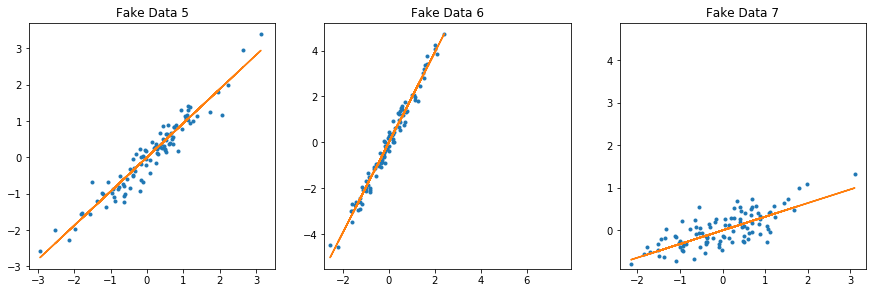

In [93]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(fake_linear_x5, fake_linear_y5, '.')
plt.plot(fake_linear_x5, fake_linear_x5 * slope_fake5)
plt.axis('square')
plt.title('Fake Data 5')
plt.subplot(1,3,2)
plt.plot(fake_linear_x6, fake_linear_y6, '.')
plt.plot(fake_linear_x6, fake_linear_x6 * slope_fake6)
plt.axis('square')
plt.title('Fake Data 6')
plt.subplot(1,3,3)
plt.plot(fake_linear_x7, fake_linear_y7, '.')
plt.plot(fake_linear_x7, fake_linear_x7 * slope_fake7)
plt.axis('square')
_ = plt.title('Fake Data 7')

#### Breakout Session

1\. Create a new pair of fake $x$ and $y$ that is 100 long called `fake_breakout_x` and `fake_breakout_y`, with `a=3.2`, `b=4.2` and `noise_sd=10`. 

In [94]:
### STUDENT ANSWER
fake_breakout_x,fake_breakout_y = create_fake_linear(100, 3.2, 4.2, 10)
### END STUDENT ANSWER

2\. Now calculate the slope for a linear regression between these two new variables. How close is it to the original `a`? Why is it close or far from the original value?

In [95]:
### STUDENT ANSWER
calc_slope(fake_breakout_x, fake_breakout_y)
### END STUDENT ANSWER

2.4435954816279479

### Estimating the Intercept: `b`

The intercept is the point on the y axis where the regression line intersects it. We can estimate it using the following equation derived in the same manner as that for the slope:

$$intercept = \bar{y} − slope*\bar{x}$$ 

where $\hat{y}$ is the mean of $y$, and $\hat{x}$ is the mean of $x$.

Let's put that equation into a helper function and use it on our fake data.

In [96]:
def calc_intercept(x, y):
    return np.mean(y) - calc_slope(x, y) * np.mean(x)

In [97]:
intercept_fake1 = calc_intercept(fake_linear_x1, fake_linear_y1)
intercept_fake2 = calc_intercept(fake_linear_x2, fake_linear_y2)
intercept_fake3 = calc_intercept(fake_linear_x3, fake_linear_y3)
intercept_fake4 = calc_intercept(fake_linear_x4, fake_linear_y4)

print('Real Intercept: %.03f, Estimated Intecept: %.03f' % (0,intercept_fake1))
print('Real Intercept: %.03f, Estimated Intecept: %.03f' % (4,intercept_fake2))
print('Real Intercept: %.03f, Estimated Intecept: %.03f' % (0,intercept_fake3))
print('Real Intercept: %.03f, Estimated Intecept: %.03f' % (-3,intercept_fake4))

Real Intercept: 0.000, Estimated Intecept: 0.000
Real Intercept: 4.000, Estimated Intecept: 4.000
Real Intercept: 0.000, Estimated Intecept: 0.000
Real Intercept: -3.000, Estimated Intecept: -3.000


Again we did perfect because there was no noise in this data. Let's add some noise and see how we do.

In [99]:
fake_linear_x8, fake_linear_y8 = create_fake_linear(100, 1.5, 5, .5)
fake_linear_x9, fake_linear_y9 = create_fake_linear(100, 5, -.4, .5)
fake_linear_x10, fake_linear_y10 = create_fake_linear(100, -2, 2, .5)

We'll estimate both the slope and intercept now so we can plot the data with the regression line.

In [100]:
intercept_fake8 = calc_intercept(fake_linear_x8, fake_linear_y8)
intercept_fake9 = calc_intercept(fake_linear_x9, fake_linear_y9)
intercept_fake10 = calc_intercept(fake_linear_x10, fake_linear_y10)

slope_fake8 = calc_slope(fake_linear_x8, fake_linear_y8)
slope_fake9 = calc_slope(fake_linear_x9, fake_linear_y9)
slope_fake10 = calc_slope(fake_linear_x10, fake_linear_y10)

print('Real Intercept: %.03f, Estimated Intecept: %.03f' % (5,intercept_fake8))
print('Real Intercept: %.03f, Estimated Intecept: %.03f' % (-.4,intercept_fake9))
print('Real Intercept: %.03f, Estimated Intecept: %.03f' % (2,intercept_fake10))


Real Intercept: 5.000, Estimated Intecept: 5.004
Real Intercept: -0.400, Estimated Intecept: -0.352
Real Intercept: 2.000, Estimated Intecept: 1.902


Again we did a good job! Let's see what it looks like.

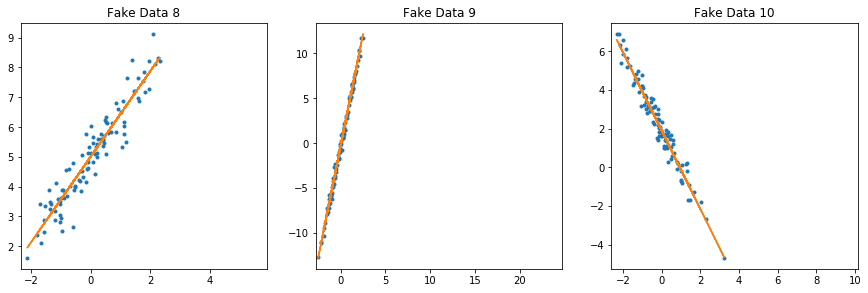

In [101]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(fake_linear_x8, fake_linear_y8, '.')
plt.plot(fake_linear_x8, fake_linear_x8 * slope_fake8 + intercept_fake8)
plt.axis('square')
plt.title('Fake Data 8')
plt.subplot(1,3,2)
plt.plot(fake_linear_x9, fake_linear_y9, '.')
plt.plot(fake_linear_x9, fake_linear_x9 * slope_fake9 + intercept_fake9)
plt.axis('square')
plt.title('Fake Data 9')
plt.subplot(1,3,3)
plt.plot(fake_linear_x10, fake_linear_y10, '.')
plt.plot(fake_linear_x10, fake_linear_x10 * slope_fake10 + intercept_fake10)
plt.axis('square')
_ = plt.title('Fake Data 10')

#### Breakout Session

1\. Estimate the intercept of a linear regression of `fake_breakout_x` onto `fake_breakout_y`. Is it close to the original `b`? Why or why not?

In [102]:
### STUDENT ANSWER
calc_intercept(fake_breakout_x, fake_breakout_y)
### END STUDENT ANSWER

4.4614294263438268

## Relationship between Correlation and Simple Linear Regression

As was suggested earlier, there is a very intersting relationship between correlation and the slope in a **Simple Linear Regression** (which is a regression with only 1 independent variable). 

If we standardize (z-score) both our x (independent) and y (dependent) variables, then the slope we find using linear regression is exactly the same as the correlation, and the intercept is 0. Let's have a look, first we'll z-score our fake data.

In [103]:
fake_linear_x10_z = scipy.stats.zscore(fake_linear_x10)
fake_linear_y10_z = scipy.stats.zscore(fake_linear_y10)

In [104]:
calc_intercept(fake_linear_x10, fake_linear_y10)

1.902310964759437

In [105]:
calc_slope(fake_linear_x10, fake_linear_y10)

-2.0248839650274966

Now let's calculate the correlation, slope and intercept for the z-scored data.

In [106]:
fake_intercept10_z = calc_intercept(fake_linear_x10_z, fake_linear_y10_z)
fake_slope10_z = calc_slope(fake_linear_x10_z, fake_linear_y10_z)
fake_correlation10_z = np.corrcoef(fake_linear_x10_z, fake_linear_y10_z)[0,1]

# print out the results
print('Linear Regression Intercept: %.06f' % (fake_intercept10_z))
print('Linear Regression Slope: %.06f' % (fake_slope10_z))
print('Correlation: %.06f' % (fake_correlation10_z))

Linear Regression Intercept: -0.000000
Linear Regression Slope: -0.977639
Correlation: -0.977639


#### Breakout Session

1\. Now z-score `fake_breakout_x` and `fake_breakout_y` and recalculate the slope on these z-scored vectors. Confirm this gives you a correlation by calculating the correlation between the original (non-zscored) vectors.

In [108]:
### STUDENT ANSWER
fake_breakout_x_z = zscore(fake_breakout_x)
fake_breakout_y_z = zscore(fake_breakout_y)

slope_z_breakout = calc_slope(fake_breakout_x_z, fake_breakout_y_z)
corr_z_breakout = np.corrcoef(fake_breakout_x_z, fake_breakout_y_z)[0,1]
slope_z_breakout, corr_z_breakout
### END STUDENT ANSWER

(0.28502944932804136, 0.28502944932804136)

## Finding the line which minimizes error

Now that we have an idea of what the slope and intercept are, let's get an intuitive sense for what values will give a good "fit" to the data using some interactive plots. This plot has two sliders, one for the slope and one for the intercept. Moving the sliders will change the slope and intercept of the red line in the plot. The data points are draw in blue, and there are lines between each data point and the regression line in green. You want the sum of all of these lines to be as small as possible. That sum is printed as a number beneath the plot. 

Try to adjust the slope and intercept to find the minimum value of that sum at the bottom, which is exactly what linear regression does!

In [110]:
def show_error_fake(slope, intercept):
    plt.figure(figsize=(15,5))
    return show_error_scatter(fake_linear_x10.reshape(-1,1), fake_linear_y10.reshape(-1,1), slope, intercept)

_ = interact(show_error_fake, 
             slope=FloatSlider(value=0, min=-5, max=5), 
             intercept=FloatSlider(value=0, min=-5, max=5))

interactive(children=(FloatSlider(value=0.0, description='slope', max=5.0, min=-5.0), FloatSlider(value=0.0, description='intercept', max=5.0, min=-5.0), Output()), _dom_classes=('widget-interact',))

### Visualizing Linear Regression in Two Ways

We learned that we can plot two vectors as time series on a line plot to get an idea of how correlated they are. We can do a very similar thing to try and guess the values for the slope and intercept of a linear regression between two vectors. This interactive plot is the same as the last one, with the addition of a time series line plot. Have a look!

In [111]:
fake_linear_x10.reshape(100,1).shape

(100, 1)

In [112]:
def show_error_fake10_both(slope, intercept):
    return show_error_both_ways(fake_linear_x10, fake_linear_y10, slope, intercept)

interactive_plot = interactive(show_error_fake10_both, 
                               slope=widgets.FloatSlider(value=0, min=-5, max=5), 
                               intercept=widgets.FloatSlider(value=0, min=-5, max=5))
output = interactive_plot.children[-1]
output.layout.height = '250px'
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='slope', max=5.0, min=-5.0), FloatSlider(value=0.0, description='intercept', max=5.0, min=-5.0), Output(layout=Layout(height='250px'))), _dom_classes=('widget-interact',))

#### Breakout Session

1\. What operations are applied to the response vector when the 'slope' and 'intersept' sliders are changed? Why does changing the values cause the error value to increase or decrease?

In [ ]:
### STUDENT ANSWER
### END STUDENT ANSWER

## Linear Regression as a Model

Linear Regression is a type of statistical model that relates the $x$ (independent variable) to the $y$ (dependent variable. But what is a statistical model?

### What is a "model"?

A **mathematical model** is a description of a system using mathematical concepts and language, usually in the form of one or more equations. A **statistical model** is a type of mathmatical model that includes assumptions about the system it is modeling, in the form of probability distributions of the random varables in the model.

Burnham & Anderson state: "A model is a simplification or approximation of reality and hence will not reflect all of reality" - whence the saying "all models are wrong". And that's why it's called a model. Think of a model car. Model cars look like a car, but are a simplification of a real car, not the real thing. All of science creates mathmatical models to formally describe the systems they study in a simple way.

So that's a more formal definition, but what is the intuition? Intuitivel, a model defines the types of relationships between the variables being modeled, and should be able to make a prediction about the outcome of system it is modeling. In our case, we are trying to model brain activity as recorded by fMRI. So the model of a voxel consists of a mathmatical equation and probablility distribution of the data. That model describes both the set of variables that affect the voxels' output, and the amount of affect each of those variables has on the output.

Let's use the category localizer that we've been using in the last few lectures as an example of a statistical linear regression model.

### Fit the model to the data to get the coefficients

We've seen how to calculate the intercept and the slope separately, but there is actually an easier way to calculate all the **weights**, which are the values for the intercept, and slope. In the language of linear regression the slope (or slopes when there are multiple $x$ as we'll see later) are called the **coefficients**. We say that we **fit** the entire linear model, which calculates the intercept and all the coefficients at one time. 

In order to fit the linear model we've created, we need to get more formal about what that model is. We've already seen the linear equation, but when we write the linear model equation there is an additional term, called the error term. Let's have a look:

\begin{align}
y_j =  w_0 + w_1 * x_j +\epsilon_j
\end{align}

where
- $y_j$ is the value of the BOLD signal at time=j
- $w_0$ is the intercept term
- $w_1$ is the slope
- $x_j$ is the value of the response vector at time=j
- $\epsilon$ is the error in the model

We need the error term because noise exists in our data, and so our model is not perfect. As we've seen when finding the slope and intercept, when we fit our model we cannot exactly recover $w_0$ and $w_1$. However, we would like to find a solution for $w_0$ and $w_1$ that minimizes the following error between the predicted values and the real values of the BOLD signal, as we saw in the plots above. This error value is the **Sum of Squared Errors (SSE)**, and we would like to minimize it as much as possible. Below is the equation for the sum of squared errors:

\begin{align}
SSE = \sum_{j = 1}^N (y_j - X_j W)^2
\end{align}

The equations for the slope and intercept that we saw above actually minimuze the $SSE$ and give us $w_0$ and $w_1$ To show how to minimize this equation for the entire model involves calculas and linear algebra which are beyond this course, but once we do that minimization, we arrive at the **Least Squares** solution. 

### Finding the slope and intercept with `LinearRegression`
Now we'll use an object called `LinearRegression()` from the `sk-learn` python module, which implements exactly the above solution to fit a linear regression model. To use it is fairly simply. 

1. First, create the `LinearRegression()` object. It has some arguments, but the defaults are just what we need for this class, so you don't have to pass any in.
2. Use the `fit()` function of this object, and pass it the x (independent) and y (dependent) variables you want to model. It will fit the model and store the values of $w_0$ and $w_1$ as two properties of the object, called `intercept_` and `coef_` respectively.

Let's try this out. First we'll import the `LinearRegression` object.

In [113]:
from sklearn.linear_model import LinearRegression

The `LinearRegression` object requires that both $x$ and $y$ are 2-d matrices, so we'll need to reshape the 1-D vectors we've been using into 2-D matrices. This is easily done using `.reshape(-1,1)`. Remember from an earlier lecture that passing `-1` to `reshape` tells it to automatically calculate the size of that dimension, and since we're telling it we want 1 column (2nd axes), it will turn the `-1` into the length of the vector. Let's do that here for both x and y. 

In [114]:
fake_linear_x10_2D = fake_linear_x10.reshape(-1,1) 
fake_linear_y10_2D = fake_linear_y10.reshape(-1,1)

Now we'll create a linear regression object, and use it to fit the fake x and y 2-D data.

In [115]:
reg_model1 = LinearRegression()
reg_model1.fit(fake_linear_x10_2D, fake_linear_y10_2D)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Now let's see if the intercept and slope we estimated by fitting the linear model are the same as those we calculated using our functions above.

In [116]:
print('Model Intercept: %.04f, and slope: %.06f' % (reg_model1.intercept_, reg_model1.coef_))
print('Functions Intercept: %.04f, and slope: %.06f' % (intercept_fake10, slope_fake10))

Model Intercept: 1.9023, and slope: -2.024884
Functions Intercept: 1.9023, and slope: -2.024884


And they are!

#### Breakout Session

1\. Fit a linear regression model to the `fake_linear_x9` and `fake_linear_y9`. Print out the intercept and coefficient.

In [117]:
### STUDENT ANSWER
reg_model2 = LinearRegression()
reg_model2.fit(fake_linear_x9.reshape(-1,1), fake_linear_y9.reshape(-1,1))
### END STUDENT ANSWER

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [118]:
print('Model Intercept: %.04f, and slope: %.06f' % (reg_model2.intercept_, reg_model2.coef_))
print('Functions Intercept: %.04f, and slope: %.06f' % (intercept_fake9, slope_fake9))

Model Intercept: -0.3522, and slope: 4.989154
Functions Intercept: -0.3522, and slope: 4.989154


### Predicted Values and Calculating SSE for a Linear Model

We now know that Linear Regression minimizes the Sum of Squared Error (SSE), which means that we can use it to get an idea of how well the model fits the data. Remember the equation for SSE is:

$$SSE = \sum_{j = 1}^N (y_j - X_j W)^2$$

Let's see how to calculate it and get an idea of exactly what it is. The first step in calculating SSE is to figure out the predicted values of $y$, %\hat{y}%. We learned above that the predicted values of y are achieved by applying the linear equation $x$:

$$\hat{y} = a * x + b$$ 

Let's calculate this using the slope and intercept we calculated with our functions.

In [119]:
fake_linear_y10_hat = slope_fake10*fake_linear_x10 + intercept_fake10

Let's plot these predicted values ("y hat"), along with the original data to see how they relate.

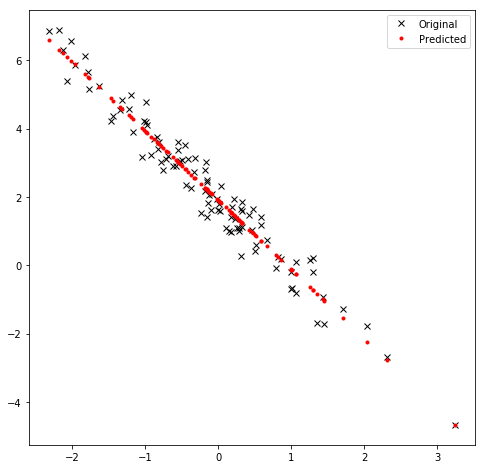

In [120]:
fig = plt.figure(figsize=(8,8))
plt.plot(fake_linear_x10, fake_linear_y10, 'xk', label='Original')
plt.plot(fake_linear_x10, fake_linear_y10_hat, '.r', label='Predicted')
_ = plt.legend()

If you noticed that the predicted values seem to fall directly on the regression line, you're correct! The regression line is the best guess we have for every value of $x$, and so every predicted value of $x$ is the value of the regression line at that point in $x$! Let's prove this by plotting the predicted values and the regression line itself.

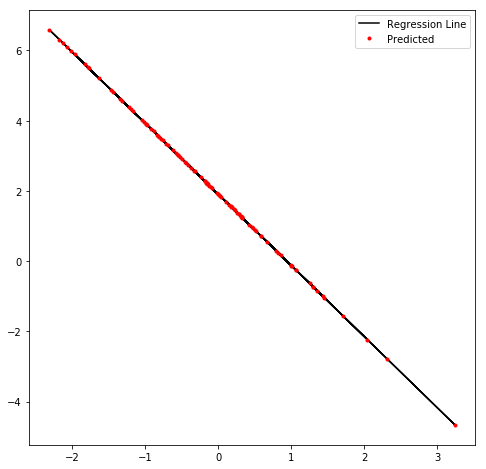

In [121]:
fig = plt.figure(figsize=(8,8))
plt.plot(fake_linear_x10, fake_linear_x10 * slope_fake10 + intercept_fake10, 'k', label='Regression Line')
plt.plot(fake_linear_x10, fake_linear_y10_hat, '.r', label='Predicted')
_ = plt.legend()

It turns out that the `LinearRegression` object has a function that will calculate the predicted values for us. It is conveniently called `.predict` and it takes the $x$ values you want to predict using the model. Then we'll test to make sure we get the same answer that we just calculated.

In [122]:
fake_linear_y10_pred = reg_model1.predict(fake_linear_x10_2D).reshape(-1)
np.allclose(fake_linear_y10_pred, fake_linear_y10_hat)

True

Now that we have the predicted values calculating SSE is straightforward. The name Sum of Squared Errors very accurately describes the calculations involved. Remember that our model included an error term called $\epsilon$. If we rewrite the linear model, we can find out how to calculate the error:

$$ \epsilon = y - (a * x + b)$$

And we can substitute the equation for $\hat{y}$ in to get the following:

$$ \epsilon = y - \hat{y}$$

So to get the Sum of the Squared Errors, we calculate the error, square each value, and sum them up! Let's do that now.

In [123]:
sse_fake_linear10 = np.sum((fake_linear_y10-fake_linear_y10_pred)**2)
sse_fake_linear10

20.360507512222419

That number might look familiar. If you were able to find the best solution for the slope and intersect in the interactive plot above, this is the same error number that would have been printed beneath the plot!

#### Breakout Session

1\. Calculate the predicted values for the linear model of `fake_linear_x9`, and use them to calculate the SSE for the model.

In [ ]:
### STUDENT ANSWER
### END STUDENT ANSWER

## Linear Regression for real fMRI data

Now let's apply linear models to some real fMRI data. We'll fit the faces response vector to our FFA voxel and see how we do.

In [ ]:
reg_model_faces = LinearRegression()
reg_model_faces.fit(faces_response_vec, data_faces)

Uh-Oh, why didn't that work? Remember that we need to reshape vectors to 1-D matrices. This is annoying now, but will become useful once we want to find regression models to multiple voxels at the same time!

In [ ]:
reg_model_faces = LinearRegression()
reg_model_faces.fit(faces_response_vec.reshape(-1,1), data_faces.reshape(-1,1))
reg_model_faces.intercept_, reg_model_faces.coef_

Let's calculate the SSE for this faces model.

In [ ]:
data_faces_pred_faces = reg_model_faces.predict(faces_response_vec.reshape(-1,1))[:,0]
faces_sse = np.sum((data_faces - data_faces_pred_faces) **2)
faces_sse

Let's plot the data and the regression line to see how well it fits.

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.plot(faces_response_vec, faces_response_vec * reg_model_faces.coef_[0] + reg_model_faces.intercept_[0], 'k', label='Regression Line')
plt.plot(faces_response_vec, data_faces, '.r', label='Face Data')
plt.xlabel('Faces Response')
plt.ylabel('BOLD Signal')
plt.title('FFA Voxel Regression')
_ = plt.legend()

#### Breakout Session

1\. Fit a linear regression model to the PPA voxel BOLD data using the `places` response vector. Plot the data as a scatter plot, and the regression line.

In [ ]:
### STUDENT ANSWER
### END STUDENT ANSWER

# Multiple Linear Regression

The real power of regression comes when we have more than one **independent variable** we want to associate with the **dependent variable**.

The case of multiple linear regression is a natural extension of the simple linear regression case. In multiple regression, we have multiple independent variables (x), and still a single dependent variable (y). Now the equation describing each time point of data looks like this: 

\begin{align}
y_j =  w_0 + w_1 x^1_j + w_2 x^2_j ... + w_3 x^d_j +\epsilon_j
\end{align}

We can rewrite this second equation for multiple regression using a more succint notation:

\begin{align}
Y =  {\bf X} * W +\epsilon
\end{align}

where
- $Y$ is the n x 1 array of BOLD data
- ${\bf X}$ is the n x 2 matrix were the first column is all 1s for the intercept and the second column is the response vector
- ${W}$ is 2 x 1, where the first value is $w_0$ and the second value is $w_1$
- $\epsilon$ is the n x 1 vector or errors, or residuals

We can write the solution to this multiple regression model as the following equation, which is what we will use to fit our model. This is just for your own information, you don't need to know this equation for any exams.:

\begin{align}
\hat W = ({\bf X}^\top{\bf X})^{-1}{\bf X}^\top Y\\
\end{align}

As it turns out, the equation that minimizes the Sum of Squared Errors (SSE) is exactly the same for the multiple regression case as it is for the simple linear regression case, so we can use the same `LinearRegression` function for both! Let's explore this...

## Extending the Face Model: Modeling Faces and Bodies

Since we know that the subject saw more than just images of faces, it makes sense that we would want to model more than just the response to faces in order to get a model that better explains the BOLD data (y). Now let's see what happens if we include the bodies response vector in the model as well...

### Intuition using time series plots

First let's plot the FFA BOLD data along with the response vectors for the faces and bodies to remind ourselves what the signal looks like when bodies were shown.

In [ ]:
_ = plt.figure(figsize=(18, 6))
_ = plt.plot(data_faces, label = 'Bold Data')
_ = plt.plot(faces_response_vec, label = 'Faces')
_ = plt.plot(bodies_response_vec, label = 'Bodies')
_ = plt.legend()

Now we need to create a 2-D $x$ matrix, which is called a **design matrix**, from the response vectors for bodies and faces. We'll use `np.stack` to do that. 

In [ ]:
designmat_faces_bodies = np.stack((faces_response_vec, bodies_response_vec), axis=1)
designmat_faces_bodies.shape

And reshape the FFA voxel BOLD data into a 2-D matrix with one column.

In [ ]:
data_faces_2D = data_faces.reshape(len(data_faces),1)

In [ ]:
def show_error_faces_bodies(intercept, slope_faces, slope_bodies):
    plt.figure(figsize=(15,5))
    show_error_time(designmat_faces_bodies, 
                    data_faces_2D, 
                    [slope_faces, slope_bodies], 
                    intercept)

interactive_plot = interactive(show_error_faces_bodies, 
                               intercept=widgets.FloatSlider(value=0, min=-5, max=5), 
                               slope_faces=widgets.FloatSlider(value=0, min=-5, max=5), 
                               slope_bodies=widgets.FloatSlider(value=0, min=-5, max=5))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

### Fit the model

Now let's fit a multiple regression model using both the faces and the bodies response vectors independent variables. We just learned that the same equation estimates the coefficients for simple and multiple linear regression, so we can use the same `LinearRegression` object to fit this multiple regression model. Instead of reshaping a single response vector into a 2-D matrix, we'll use the design matrix we just created. We'll use the reshaped FFA voxel BOLD data and fit the model.

In [ ]:
reg_model_face_body = LinearRegression()
reg_model_face_body.fit(designmat_faces_bodies, data_faces_2D)

Let's have a look at the coefficient for faces from this model and from the first regression model of faces that we built. There are 2 slope coefficients now, and since the faces response vector was in the first column, the first coefficient is for faces.

In [ ]:
print('Faces Coefficient with Bodies: %.03f' % (reg_model_face_body.coef_[0][0]))
print('Faces Coefficient Only: %.03f' % (reg_model_faces.coef_[0][0]))

The two coefficients are similar, but not the same! We'll learn more about why this is later on. 

For now let's predict the original data using this faces and bodies model, and then calculate the sum of squared error (SSE) of this new model. Then we can compare this SSE value with the SSE we calculated above for the faces only model. 

In [ ]:
data_faces_pred_facebody = reg_model_face_body.predict(designmat_faces_bodies)[:,0]
faces_bodies_sse = np.sum((data_faces - data_faces_pred_facebody)**2)
faces_bodies_sse, faces_sse

Since the SSE for the faces bodies model is lower than that for the faces only model we can conclude that including the bodies response vector into the model improves the fit!

#### Breakout Session

1\. Fit a multiple linear regression model to the PPA voxel that has 2 independent variables, the `scenes` and `object` response vectors. Calculate the predicted values, and use them to calculate the SSE.

In [ ]:
### STUDENT ANSWER
### END STUDENT ANSWER

## The Full Model with All the Categories

We saw that the model that incorporated bodies and faces did a better job than the model which just incorporated faces. Let's see what happens when we include the response vectors that describe all the stimuli that the subject saw.

First we need to create the design matrix for the all the stimulus types. We'll use `np.stack` again to do this.

In [ ]:
designmat_full = np.stack((faces_response_vec, bodies_response_vec, places_response_vec, objects_response_vec, scrambled_response_vec), axis=1)
designmat_full.shape

Now we'll fit a multiple regression model in the same way.

In [ ]:
reg_model_full = LinearRegression()
reg_model_full.fit(designmat_full, data_faces_2D)

And let's predict and calculate the SSE again, so we can compare it with the faces bodies model.

In [ ]:
data_faces_pred_full = reg_model_full.predict(designmat_full)[:,0]
full_sse = np.sum((data_faces-data_faces_pred_full)**2)
print('Just using Faces and bodies, SSE is: %.02f, adding all categories SSE is: %.02f' % (faces_bodies_sse, full_sse))

It seems the SSE is slightly lower when adding all of the response vectors, but not by much! What matters in statistcs is whether this is **significantly** lower. We'll learn about significance testing later in the semester.

#### Breakout Session

1\. Fit the full model (of all 5 stimulus types) to the PPA voxel. Does the SSE increase dramatically relative to the SSE from the model of just scenes and objects?

In [ ]:
### STUDENT ANSWER
### END STUDENT ANSWER

## So Why Do We Need Multiple Regression?

We just saw that simple and multiple linear regression don't always estimate the same value for coefficients of the same $x$ variable (the faces response). So why would we want to use multiple regression instead of estimate the coffecicents of a number of simple linear regression models?

The answer is that when there is a correlation between the $x$ variables, multiple regression can account for that correlation, whereas doing several simple regressions cannot. In other words, multiple regression controls for correlation in the independent variables that lead to a more accurate estimation of all the slopes.

Let's take a look at an example to see how this works. We'll create 2 independent variables that are correlated, and then use the linear equation to create the y data.

In [ ]:
fake_multi_x1, fake_multi_x2 = create_fake_data(100, 0, 0, .5)
intercept_real1 = 0
coef_real1 = 1.5
coef_real2 = -2
fake_multiple_y1 = intercept_real1 + fake_multi_x1 * coef_real1 + fake_multi_x2 * coef_real2 
fake_multiple_y1 += np.random.randn(100) * .3

Now let's use 2 simple linear models to estimate the two coefficeints separately.

In [ ]:
reg_model_simple1 = LinearRegression()
reg_model_simple1.fit(fake_multi_x1.reshape(-1,1), fake_multiple_y1.reshape(-1,1))
reg_model_simple2 = LinearRegression()
reg_model_simple2.fit(fake_multi_x2.reshape(-1,1), fake_multiple_y1.reshape(-1,1))
print('Real Coefficient 1: %.03f, Simple Estimated Coefficient 1: %.03f' % (coef_real1, reg_model_simple1.coef_[0][0]))
print('Real Coefficient 2: %.03f, Simple Estimated Coefficient 2: %.03f' % (coef_real2, reg_model_simple2.coef_[0][0]))

That's not so great. Now let's see what happens when we put both independent variables in the model.

In [ ]:
designmat_fake_multiple = np.stack((fake_multi_x1, fake_multi_x2), axis=1)
reg_model_multi1 = LinearRegression()
reg_model_multi1.fit(designmat_fake_multiple, fake_multiple_y1.reshape(-1,1))
print('Real Coefficient 1: %.03f, Simple Estimated Coefficient 1: %.03f' % (coef_real1, reg_model_multi1.coef_[0][0]))
print('Real Coefficient 2: %.03f, Simple Estimated Coefficient 2: %.03f' % (coef_real2, reg_model_multi1.coef_[0][1]))

That's more like it! 

So the multiple regression model can account for the correlation between the two independent variables, and therefore find a much better estimate of the coefficients! That's why it's important to include all the independent variables you think may influces the dependent variable. 